### Imp: 
#### 1. Why the specific order of the wavenumbers
#### 2. Why to set the first element of the fourier transform as zero

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [2]:
# from jax import config
# config.update("jax_enable_x64", True)

## Constants

In [3]:
L = 1.
NX = NY = 512
X_START = 0.
X_END = L
Y_START = 0.
Y_END = L

## Space-Time Domain

In [4]:
x = jnp.linspace(X_START, X_END, NX + 1)
y = jnp.linspace(Y_START, Y_END, NY + 1)
X, Y = jnp.meshgrid(x, y)

In [5]:
dx = x[1] - x[0]
dy = y[1] - y[0]

In [6]:
hx = 2. * jnp.pi / (NX * dx)

## Intial Condition Functions

In [7]:
u = (lambda x, y: jnp.sin(2.*jnp.pi*x) * jnp.sin(2.*jnp.pi*y) + (1./16.**2) * jnp.sin(32.*jnp.pi*x) * jnp.sin(32.*jnp.pi*y))
f = (lambda x, y: -8 * jnp.pi**2 * jnp.sin(2*jnp.pi*x) * jnp.sin(2*jnp.pi*y) - 8 * jnp.pi**2 * jnp.sin(32.*jnp.pi*x) * jnp.sin(32.*jnp.pi*y))

## Initial Conditions

In [8]:
U = u(X, Y)
F = f(X, Y)

In [9]:
m_arr = jnp.empty(NX)
m_arr = m_arr.at[jnp.arange(0, int(NX/2))].set(hx * jnp.arange(0, int(NX/2))) 
m_arr = m_arr.at[jnp.arange(int(NX/2), NX)].set(hx * jnp.arange(-int(NX/2), 0))
n_arr = m_arr.clone()

In [10]:
u_tilda_den = lambda m, n: (-(m**2 + n**2))
den_jax = jax.vmap(jax.vmap(u_tilda_den, in_axes=(0, None)), in_axes=(None, 0))(m_arr, n_arr)

In [11]:
den_jax = den_jax.at[0,0].set(jnp.finfo(float).eps)

## Main Function

In [12]:
def poisson_fft_spectral_direct_solver(F, den):
    F_tilda = jnp.fft.fftn(F[:-1, :-1].astype(complex))
    F_tilda = F_tilda.at[0,0].set(complex(0,0))    
    U_tilda = F_tilda/den
    return jnp.real(jnp.fft.ifftn(U_tilda))

In [13]:
U_numerical = poisson_fft_spectral_direct_solver(F, den_jax)

## Periodic Boundary Conditions

In [14]:
U_final = jnp.zeros_like(U)
U_final = U_final.at[:-1, :-1].set(U_numerical)
U_final = U_final.at[-1,:-1].set(U_numerical[0, :])
U_final = U_final.at[:-1,-1].set(U_numerical[:, 0])

## Plotting

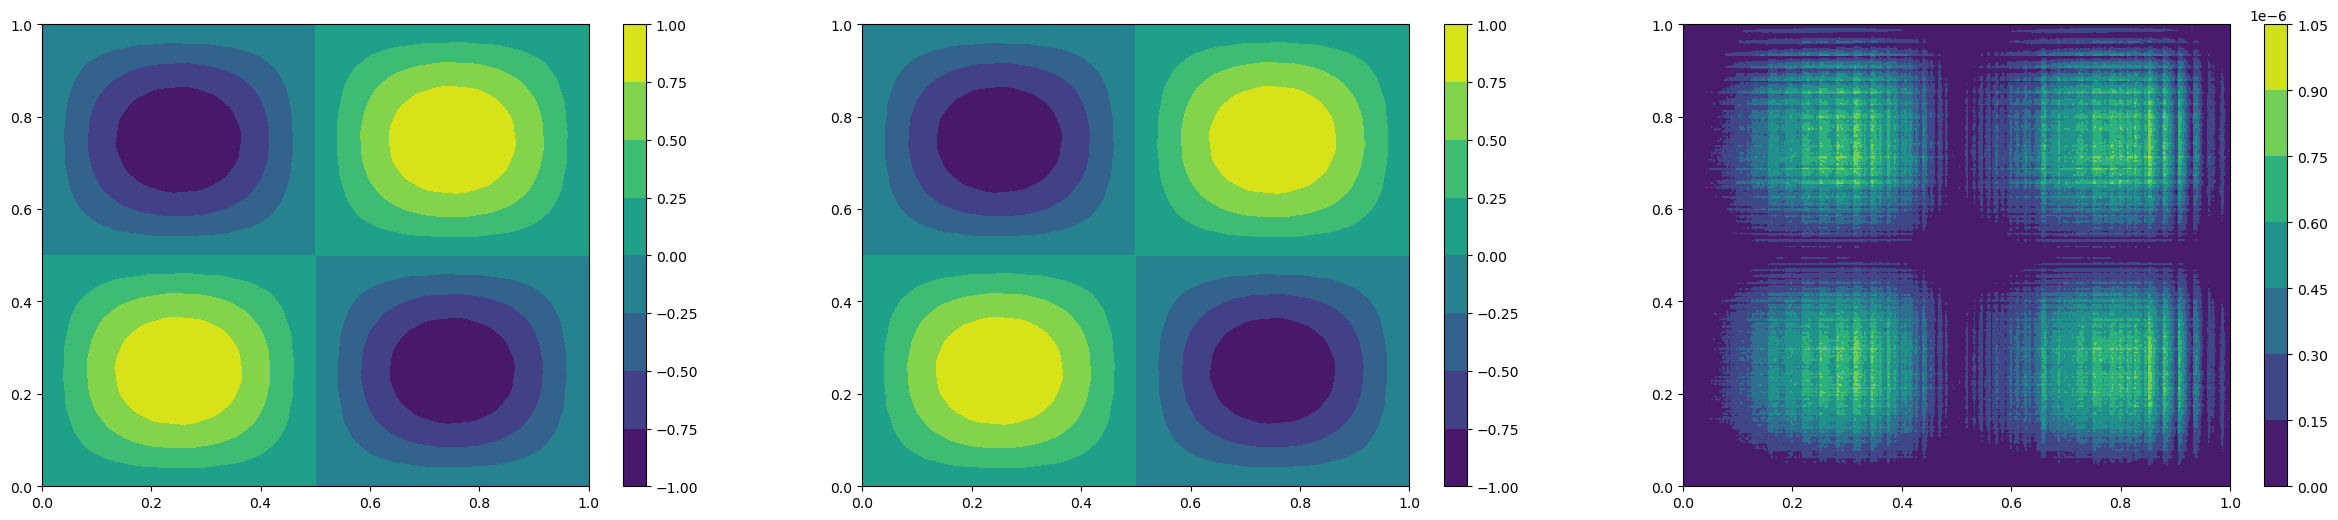

In [15]:
fig, axs = plt.subplots(1,3, figsize=(30,6))
num = axs[0].contourf(X, Y, U_final)
gt = axs[1].contourf(X, Y, U)
err = axs[2].contourf(X, Y, jnp.absolute(U - U_final))
fig.colorbar(num)
fig.colorbar(gt)
fig.colorbar(err)
plt.show()